## Fly Cell Atlas 10X Genomics Testis Male Germline Analysis

In [ ]:
processx::run("wget", "https://cloud.flycellatlas.org/index.php/s/kR9W49Qj9FoeyT8/download/testis.h5ad")

In [5]:
library(callr)
library(dplyr)
library(Matrix)
library(reticulate)
library(Seurat)
library(stringr)

Conversion

In [7]:
gtf <- read.table("dmel-all-r6.31.gtf.gz", sep="\t", quote="")
rowData <- with(
  subset(gtf, V3 == "gene"),
  tibble(
    rowname = str_extract(V9, "gene_symbol \"([^\"]+)\"", group=1),
    flybaseid = str_extract(V9, "gene_id \"([^\"]+)\"", group=1),
    chr = V1,
    start = V4,
    end = V5,
    strand = V7,
  )
)
write.csv(rowData, "dmel-all-r6.31-rowData.csv", row.names = F)

In [6]:
rowData <- read.csv("dmel-all-r6.31-rowData.csv")

In [9]:
Ypath <- r(
  \() {
    library(dplyr)
    library(Matrix)
    library(reticulate)
    use_virtualenv("r-reticulate")
    anndata <- import("anndata", convert=FALSE)
    builtins <- import("builtins", convert=FALSE)
    numpy <- import("numpy", convert=FALSE)
    ann <- anndata$read_h5ad("testis.h5ad")
    Y <- sparseMatrix(
      i = 1 + py_to_r(ann$X$indices$tolist()),
      p = py_to_r(ann$X$indptr$tolist()),
      x = py_to_r(ann$X$data$astype(builtins$int)$tolist())
    )
    Y <- as.matrix(Y)
    rownames(Y) <- py_to_r(ann$var$index$values$tolist())
    colnames(Y) <- py_to_r(ann$obs$index$values$tolist())
    rowData <- read.csv("dmel-all-r6.31-rowData.csv")
    Y <- Y[match(rowData$rowname, rownames(Y)), ]
    Y[is.na(Y)] <- 0
    rownames(Y) <- rowData$rowname
    Y <- as(Y, "sparseMatrix")
    output_path <- "testis-counts.rds"
    saveRDS(Y, output_path)
    output_path
  }
)

In [7]:
Ypath <- "testis-counts.rds"

In [4]:
colData <- r(
  \() {
    library(dplyr)
    library(forcats)
    library(MatrixGenerics)
    library(reticulate)
    library(scuttle)
    library(Seurat)
    library(stringr)
    use_virtualenv("r-reticulate")
    anndata <- import("anndata", convert=FALSE)
    builtins <- import("builtins", convert=FALSE)
    numpy <- import("numpy", convert=FALSE)
    ann <- anndata$read_h5ad("testis.h5ad")
    Y <- readRDS("testis-counts.rds")
    rowData <- read.csv("dmel-all-r6.31-rowData.csv")
    colData <- tibble(
      rowname = py_to_r(ann$obs$index$values$tolist()),
      as_tibble(
        CreateSeuratObject(counts = Y)@meta.data
      ),
      ident = factor(
        py_to_r(ann$obs$annotation$tolist())
      ) %>%
        fct_relevel(
          c(
            "spermatogonium",
            "mid-late proliferating spermatogonia",
            "spermatogonium-spermatocyte transition",
            "spermatocyte 0",
            "spermatocyte 1",
            "spermatocyte 2",
            "spermatocyte 3",
            "spermatocyte 4",
            "spermatocyte 5",
            "spermatocyte 6",
            "spermatocyte 7a",
            "late primary spermatocyte",
            "early elongation stage spermatid",
            "early-mid elongation-stage spermatid",
            "mid-late elongation-stage spermatid",
            "cyst stem cell",
            "early cyst cell 1",
            "early cyst cell 2",
            "cyst cell intermedate",
            "spermatocyte cyst cell branch a",
            "spermatocyte cyst cell branch b",
            "cyst cell branch a",
            "cyst cell branch b",
            "late cyst cell branch a",
            "late cyst cell branch b",
            "adult fat body",
            "muscle cell"
          )
        ),
      technology = py_to_r(ann$obs$technology$tolist()) %>% factor(),
      batch = factor(
        str_extract(rowname, "sample[123]"),
        c("sample1", "sample2", "sample3", "ss2")
      ) %>%
        replace(technology == "ss2", "ss2"),
      pctMito = colSums2(
        Y[rowData$chr == "mitochondrion_genome", ]
      ) /
        colSums2(Y) *
        100,
      as_tibble(
        CreateSeuratObject(Y) %>%
          PercentageFeatureSet("^Rp[SL]", col.name = "pctRibo") %>%
          FetchData("pctRibo")
      ),
      size_factor = pooledSizeFactors(
        Y,
        clusters = ident
      ),
    )
    saveRDS(colData, "testis-colData.rds")
    colData
  }
)
print(colData, width=180)

# A tibble: 43,828 × 10
   rowname                                                               
   <chr>                                                                 
 1 AAACCCACACGGCGTT-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 2 AAACCCACATTACTCT-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 3 AAACCCAGTACGGCAA-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 4 AAACCCAGTCGTAATC-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 5 AAACCCAGTCGTATGT-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 6 AAACCCAGTGCGACAA-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 7 AAACCCATCGCACTCT-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 8 AAACCCATCTCCACTG-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
 9 AAACGAAAGCATTTGC-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
10 AAACGAAAGCGGTATG-6e669170__FCA59_Male_testis_adult_1dWT_Fuller_sample1
   orig.ident    nCount_RNA nFeature_RNA ident                              
   <fct>   

In [8]:
colData <- readRDS("testis-colData.rds")

In [12]:
percentageExpression <- r(
  function() {
    library(dplyr)
    library(Matrix)
    library(tibble)
    counts <- readRDS("testis-counts.rds")
    colData <- readRDS("testis-colData.rds")
    celltype_counts <- table(colData$ident)
    data <- tibble(
      gene = 1+counts@i,
      cell = rep(seq(ncol(counts)), diff(counts@p)),
      celltype = colData$ident[cell],
    ) %>%
      group_by(gene, celltype) %>%
      tally()
    result <- sparseMatrix(
      i = data$gene,
      j = as.numeric(data$celltype),
      x = data$n,
      dims = c(nrow(counts), length(celltype_counts)),
      dimnames = list(
        rownames(counts),
        names(celltype_counts)
      )
    ) %>%
      as.matrix()
    result <- result / rep(celltype_counts, each=nrow(counts))
    write.csv(result %>% as.data.frame() %>% rownames_to_column("symbol"), "testis-percentExpression.csv", row.names=F)
    result <- result
  },
  show=T
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Seurat Workflow

The features to use (per biological replicate) will be the union of 3000 Seurat Variable Features (Log Normalized), and 2000 Seurat Variable Features (Log Normalized) on the "spermatogonium" cluster's within-variance alone. In the Fly Cell Atlas, there is a rare cell type "germline stem cell" that all seem to be contained by the single cluster labeled "spermatogonium", so this within-cluster variance is highly meaningful to us.

Next, the final features are determined by Seurat (total 5000) by first prioritizing features that appear in all 3 replicates' variable features list, then in descending order of priority, features that appear in 2 or 1 of the lists of 5000 features. The "integrated" assay is only calculated for the var features list that is determined in advance. We will use the "integrated" assay for PCA and for SPCA.

In [ ]:
var.features <- r(
  function() {
    library(dplyr)
    library(Seurat)
    library(tibble)
    library(withr)
    tenx <- CreateSeuratObject(
      readRDS("testis-counts.rds"),
      meta.data = column_to_rownames(readRDS("testis-colData.rds"))
    )
    tenx[["RNA"]]@meta.features <- read.csv("dmel-all-r6.31-rowData.csv") %>%
      column_to_rownames()
    tenx <- tenx %>% subset(technology == "10x")
    tenx$batch <- tenx$batch %>%
      factor(c("sample1", "sample2", "sample3")) %>%
      `contrasts<-`(value = contr.sum(3))

    set.seed(0)
    Idents(tenx) <- tenx$ident
    tenx <- tenx %>%
      SplitObject("batch") %>%
      lapply(
        \(x) x %>%
          NormalizeData(verb = F) %>%
          FindVariableFeatures(nfeatures = 2000, verb = F) %>%
          `VariableFeatures<-`(
            value = union(
              VariableFeatures(.),
              subset(
                .,
                ident = "spermatogonium"
              ) %>%
                FindVariableFeatures(nfeatures = 2000, verb = F) %>%
                VariableFeatures()
            )
          )
      ) %>%
      SelectIntegrationFeatures(
        nfeatures = 2000
      )
  },
  show = TRUE
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject


In [ ]:
# Genes of interest, including GSC (nos, vas), SG (Mst87F, Amph, Hsromega), and other (tj).
sapply(
  c("nos", "vas", "Mst87F", "Amph", "Hsromega", "tj"),
  \(n) head(grep(n, var.features, val=T), 1)
)

$nos
[1] "nos"

$vas
character(0)

$Mst87F
character(0)

$Amph
[1] "Amph"

$Hsromega
[1] "lncRNA:Hsromega"

$tj
[1] "tj"

In [1]:
library(callr)
tenx <- r(
  function() {
    library(dplyr)
    library(Seurat)
    library(tibble)
    tenx <- CreateSeuratObject(
      readRDS("testis-counts.rds"),
      meta.data = column_to_rownames(readRDS("testis-colData.rds"))
    )
    tenx[["RNA"]]@meta.features <- read.csv("dmel-all-r6.31-rowData.csv") %>%
      column_to_rownames()
    tenx <- tenx %>% subset(technology == "10x")
    tenx$batch <- tenx$batch %>%
      factor(c("sample1", "sample2", "sample3")) %>%
      `contrasts<-`(value = contr.sum(3))

    percentageExpression <- read.csv("testis-percentExpression.csv")
    spermatogoniumFeatures <- percentageExpression$symbol[percentageExpression$spermatogonium >= 0.25]
    set.seed(0)
    Idents(tenx) <- tenx$ident
    tenx <- tenx %>%
      SplitObject("batch") %>%
      lapply(
        \(x) x %>%
          NormalizeData(verb = F) %>%
          FindVariableFeatures(nfeatures = 3000, verb = F) %>%
          `VariableFeatures<-`(
            value = union(
              VariableFeatures(.),
              subset(
                .,
                ident = "spermatogonium"
              ) %>%
                FindVariableFeatures(nfeatures = 2000, verb = F) %>%
                VariableFeatures()
            )
          )
      ) %>%
      FindIntegrationAnchors(dims = 1:25, anchor.features = 5000) %>%
      IntegrateData(dims = 1:25)
    saveRDS(tenx[["integrated"]], "testis-integrated.rds")
    tenx
  },
  show = TRUE
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Computing 5000 integration features
Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 29664 anchors
Filtering anchors
	Retained 15122 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 30291 anchors
Filtering anchors
	Retained 15331 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 29582 anchors
Filtering anchors
	Retained 14989 anchors
Merging dataset 2 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Inte

In [ ]:
scale.data <- r(
  function() {
    library(dplyr)
    library(Seurat)
    library(tibble)
    library(withr)
    tenx <- CreateSeuratObject(
      readRDS("testis-counts.rds"),
      meta.data = column_to_rownames(readRDS("testis-colData.rds"))
    )
    tenx[["RNA"]]@meta.features <- read.csv("dmel-all-r6.31-rowData.csv") %>%
      column_to_rownames()
    tenx <- tenx %>% subset(technology == "10x")
    tenx$batch <- tenx$batch %>%
      factor(c("sample1", "sample2", "sample3")) %>%
      `contrasts<-`(value = contr.sum(3))

    set.seed(0)
    tenx <- tenx %>%
      SplitObject("batch") %>%
      lapply(
        \(x) x %>%
          NormalizeData(verb = F) %>%
          FindVariableFeatures(nfeatures = 2000, verb = F)
      )
    var.features <- SelectIntegrationFeatures(
      object.list = tenx,
      nfeatures = 3000
    )
    var.features <- var.features[
      order(match(var.features, rownames(tenx[[1]])))
    ]
    tenx <- CreateSeuratObject(
      readRDS("testis-counts.rds"),
      assay = "RNA"
    )
    integrated <- readRDS("testis-integrated.rds")
    tenx <- tenx[, Cells(integrated)]
    tenx[["integrated"]] <- integrated
    DefaultAssay(tenx) <- "integrated"
    VariableFeatures(tenx) <- rownames(integrated)
    tenx$logFeature <- log(tenx$nFeature_RNA) / log(10)
    tenx <- tenx %>%
      ScaleData(
        features = var.features,
        vars.to.regress = c("logFeature", "pctMito")
      )
    scale.data <- tenx[["integrated"]]@scale.data
    saveRDS(scale.data, "testis-scale.data.rds")
    scale.data
  },
  show = TRUE
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Regressing out logFeature
  |======================================================================| 100%
Centering and scaling data matrix
  |======================================================================| 100%


In [12]:
scale.data <- r(
  function() {
    library(callr)
    library(dplyr)
    library(Seurat)
    library(tibble)
    library(withr)
    tenx <- CreateSeuratObject(
      readRDS("testis-integrated.rds"),
      assay = "integrated",
      meta.data = column_to_rownames(readRDS("testis-colData.rds")) %>%
        subset(batch %in% c("sample1", "sample2", "sample3"))
    )
    tenx <- tenx %>%
      AddMetaData(
        r(
          function() {
            library(dplyr)
            library(Seurat)
            library(tibble)
            readRDS("testis-counts.rds") %>%
              CreateSeuratObject(
                meta.data = column_to_rownames(readRDS("testis-colData.rds"))
              ) %>%
              subset(batch %in% c("sample1", "sample2", "sample3")) %>%
              FetchData("nFeature_RNA") %>%
              within(logFeature <- log(nFeature_RNA) / log(10))
          }
        )
      )
    tenx$batch <- tenx$batch %>%
      factor(c("sample1", "sample2", "sample3")) %>%
      `contrasts<-`(value = contr.sum(3))
    VariableFeatures(tenx) <- rownames(tenx)

    tenx <- tenx %>%
      ScaleData(
        vars.to.regress = c("logFeature", "pctMito")
      )
    scale.data <- tenx[["integrated"]]@scale.data
    saveRDS(scale.data, "testis-scale.data.rds")
    scale.data
  },
  show = TRUE
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Regressing out logFeature, pctMito
  |======================================================================| 100%
Centering and scaling data matrix
  |======================================================================| 100%


Now load the results, run PCA, and run UMAP.

In [2]:
library(dplyr)
library(Matrix)
library(Seurat)
library(tibble)
library(withr)
write.table(Sys.time(), stderr())
tenx <- CreateSeuratObject(
  readRDS("testis-counts.rds"),
  meta.data = column_to_rownames(readRDS("testis-colData.rds"))
)
tenx[["RNA"]]@meta.features <- read.csv("dmel-all-r6.31-rowData.csv") %>%
  column_to_rownames()
tenx <- tenx %>% subset(technology == "10x")
tenx$batch <- tenx$batch %>%
  factor(c("sample1", "sample2", "sample3")) %>%
  `contrasts<-`(value = contr.sum(3))
Idents(tenx) <- tenx$ident

tenx[["integrated"]] <- readRDS("testis-integrated.rds")
DefaultAssay(tenx) <- "integrated"
tenx[["integrated"]]@scale.data <- readRDS("testis-scale.data.rds")
tenx <- with_seed(
    0,
    tenx %>%
        RunPCA() %>%
        RunUMAP(dims = 1:15)
)

Attaching SeuratObject

PC_ 1 
Positive:  lncRNA:Hsromega, shep, CG9932, mgl, mtgo, luna, Gmap, pyd, Eip75B, caps 
	   Pdp1, shot, ed, Eip93F, par-1, RapGAP1, cv-c, CG43658, Samuel, tai 
	   bun, jvl, Pde11, Atpalpha, nuf, kek5, Rbp6, CG42663, mamo, SNF4Agamma 
Negative:  lncRNA:CR43264, Pzl, Myo81F, side-VI, bru1, asRNA:CR44370, kl-3, Ppr-Y, CG44774, lovit 
	   CG40470, salto, WDY, Fkbp12, lncRNA:CR43803, bru3, Snap25, soti, SteXh:CG42398, kl-2 
	   CG34434, twi, CG43291, CG14183, dac, CG3491, DIP-lambda, CG31740, CG15040, Mst84Da 
PC_ 2 
Positive:  retn, Lim1, CG18628, NAAT1, NT5E-2, CG15117, CG9664, Hex-A, CG33970, unc-13-4A 
	   bbg, CG15096, Idgf4, CG10960, dpr10, CG15822, CG7778, 5-HT2A, tim, fus 
	   Drip, CG10407, MFS9, Kank, lncRNA:CR43684, CG42237, CG14507, Clk, CG6959, GlcAT-P 
Negative:  trol, sky, Swim, CG42673, fru, Sdc, bab2, Ten-a, DIP-theta, metro 
	   Cyp6a16, mld, Wnt4, CG1674, pain, Dyrk2, bt, up, fax, pan 
	   CG33521, sls, Mhc, CG42238, jigr1, Sema5c, Prm, CG32532

We selected the diploid germline cells (spermatogonium cell type containing the putative germline stem cells, plus spermatocytes), using the PCA UMAP with a rectangular selection for further analysis. The rectangle should select a "fully connected component", e.g., it should be selecting a major group of clusters very unambiguously, without any clusters near the boundaries.

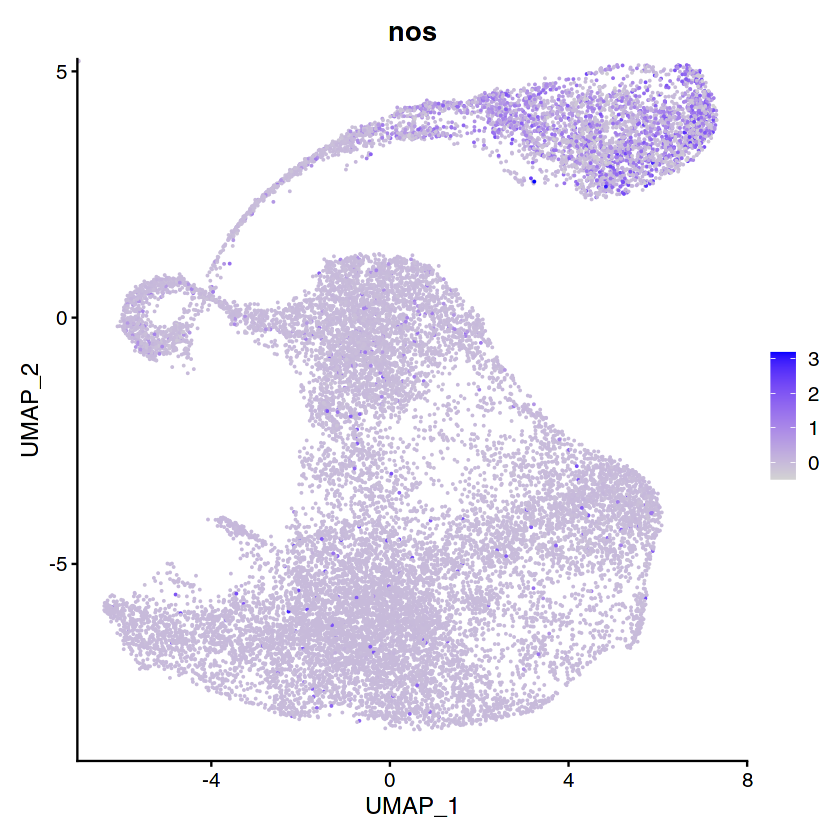

In [18]:
library(ggplot2)
xmin <- -7
xmax <- 8
ymin <- -9
ymax <- 5.25
FeaturePlot(tenx, "nos") + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

In [4]:
FetchData(tenx, c("UMAP_1", "UMAP_2", "ident")) %>%
  subset(between(UMAP_1, -10, 0) & between(UMAP_2, -8, 0)) %>%
  pull(ident) %>%
  droplevels() %>%
  table() %>%
  sort(dec=T)

.
             early elongation stage spermatid 
                                         4378 
                                 spermatocyte 
                                         1723 
                              spermatocyte 7a 
                                          346 
                                    spermatid 
                                          297 
                                 pigment cell 
                                          204 
                               spermatocyte 4 
                                          139 
                                      unknown 
                                          118 
                               adult fat body 
                                           82 
secretory cell of the male reproductive tract 
                                           75 
         early-mid elongation-stage spermatid 
                                           51 
                               spermatocyte 6 
           

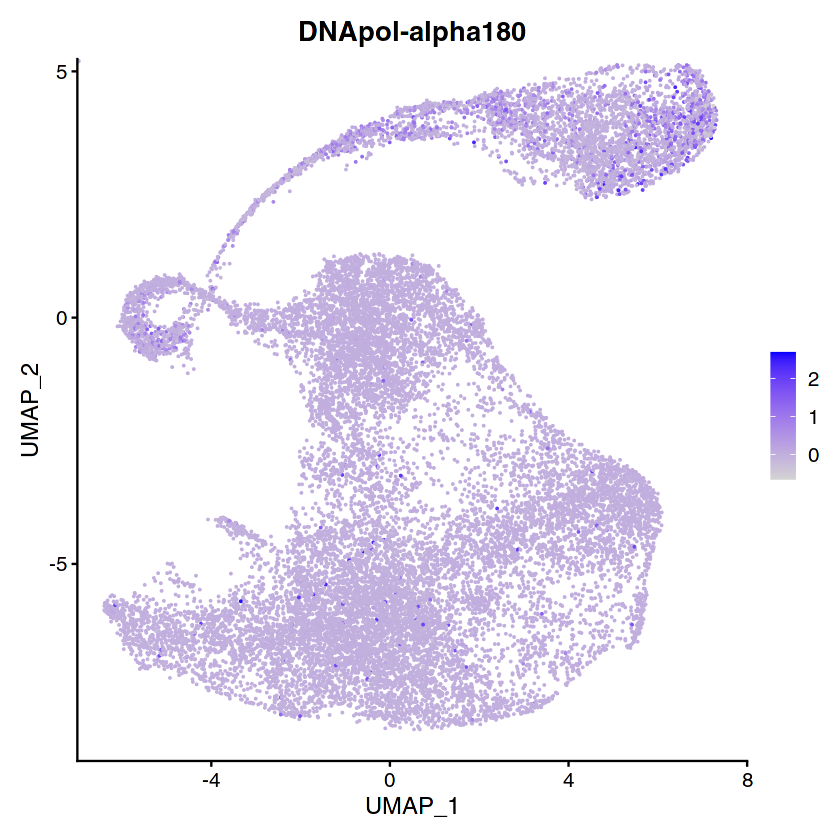

In [5]:
library(ggplot2)
FeaturePlot(tenx, "DNApol-alpha180") + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

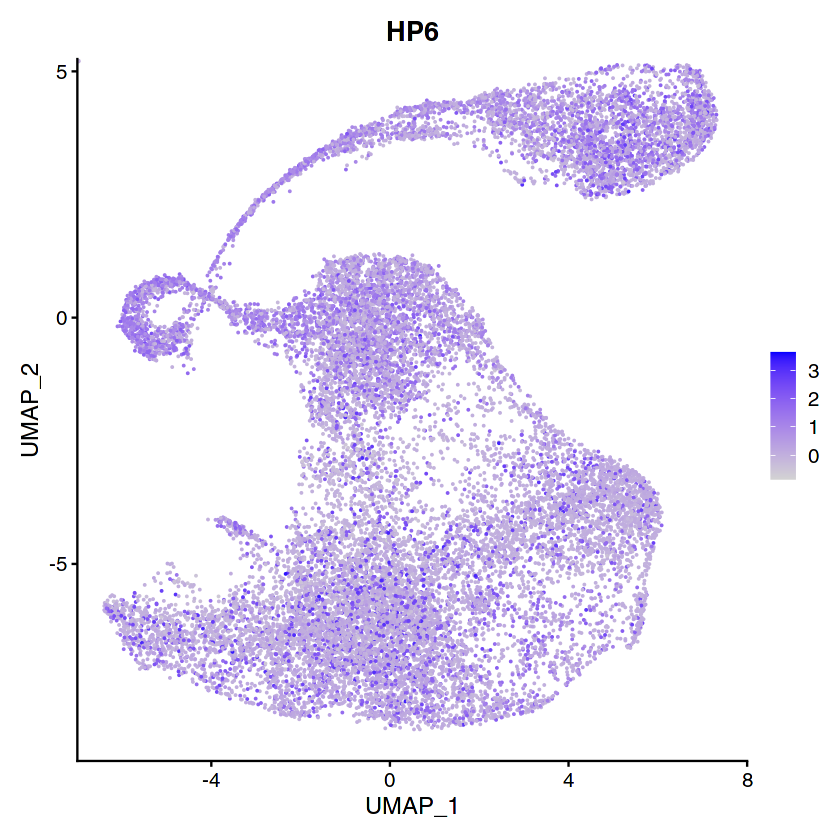

In [117]:
library(ggplot2)
FeaturePlot(tenx, "HP6") + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

Differentiation Marker Gene

In [84]:
FindMarkers(
  tenx,
  ident.1 = c("spermatocyte 3", "spermatocyte 4"),
  ident.2 = c("spermatogonium", "mid-late proliferating spermatogonia"),
  only.pos = T
) %>%
  head(50)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
qvr             6.243932e-228 1.7145412  0.981 0.166 3.121966e-224
CG3491          5.155000e-223 1.6098818  0.998 0.155 2.577500e-219
side-VI         1.262717e-222 1.5907963  1.000 0.658 6.313584e-219
l(2)41Ab        4.031138e-220 1.8513246  1.000 0.426 2.015569e-216
CG5065          2.042273e-217 1.4696010  0.996 0.157 1.021137e-213
CG31601         1.560719e-215 1.4697550  0.996 0.248 7.803596e-212
CG17839         3.103822e-215 1.4719773  0.973 0.085 1.551911e-211
Pzl             1.726892e-213 0.7444958  1.000 0.941 8.634461e-210
bru3            4.001346e-213 1.9521483  0.992 0.135 2.000673e-209
Myo81F          1.020463e-212 0.3364888  1.000 0.999 5.102314e-209
heph            7.831597e-212 0.6017977  1.000 0.966 3.915798e-208
blanks          1.547668e-204 1.2030528  1.000 0.544 7.738340e-201
CG12493         8.002003e-194 1.1379665  1.000 0.482 4.001002e-190
CG15040         6.500324e-193 1.2281568  0.938 0.132 3.250162e-189
NK7.1           8.615511e-193 1.0429743  0.926 0.062 4.307755e-189
CG44774         1.026684e-192 0.4602130  1.000 0.970 5.133419e-189
lovit           1.832880e-191 0.7039469  1.000 0.828 9.164399e-188
Su(Ste):CR42439 5.623876e-190 1.3241959  0.973 0.309 2.811938e-186
kl-3            1.678019e-187 1.5031847  0.981 0.357 8.390097e-184
hpRNA:CR18854   2.453471e-186 1.1602973  0.986 0.353 1.226735e-182
WDY             3.362925e-186 1.6722548  0.957 0.266 1.681463e-182
DIP-lambda      2.978360e-180 0.9186316  1.000 0.791 1.489180e-176
SteXh:CG42398   1.437449e-179 1.2998631  0.909 0.085 7.187247e-176
CG34434         1.740530e-179 0.9135598  1.000 0.632 8.702652e-176
Zasp52          3.554212e-165 0.9491937  0.994 0.549 1.777106e-161
Gld2            8.151651e-164 1.0133643  0.988 0.433 4.075826e-160
CG9899          1.227039e-159 0.9387314  0.872 0.081 6.135195e-156
CG8072          1.563246e-157 0.9992346  0.940 0.296 7.816232e-154
shakB           4.324104e-157 0.8784778  0.856 0.190 2.162052e-153
bab1            6.252160e-157 0.9793553  0.986 0.433 3.126080e-153
lncRNA:CR46007  4.108746e-152 0.9562949  0.926 0.241 2.054373e-148
ds              5.609880e-150 0.6525847  1.000 0.771 2.804940e-146
bab2            1.069717e-148 0.9742636  0.942 0.332 5.348584e-145
Fkbp12          1.103561e-148 0.3560304  1.000 0.964 5.517805e-145
RpS10a          3.614088e-147 0.8375468  0.992 0.627 1.807044e-143
CG43291         8.309391e-147 0.9190939  0.881 0.282 4.154696e-143
Mtl             1.195309e-145 0.8198637  0.994 0.607 5.976547e-142
lncRNA:CR43764  1.124620e-144 0.9133801  0.918 0.348 5.623100e-141
Cda5            1.025401e-143 0.7897616  0.994 0.582 5.127003e-140
COX8            3.506546e-143 0.7730709  0.996 0.632 1.753273e-139
lov             5.829200e-142 1.0278023  0.809 0.058 2.914600e-138
CR42530         8.084470e-141 0.8267169  0.868 0.270 4.042235e-137
tun             5.229138e-138 0.7891650  0.996 0.632 2.614569e-134
CG2034          5.864631e-138 0.8641758  0.984 0.484 2.932316e-134
Glut4EF         8.396325e-138 0.5553127  0.656 0.022 4.198163e-134
COX6B           1.112913e-136 0.5959714  1.000 0.808 5.564566e-133
CG33310         6.357247e-132 0.7079153  0.755 0.125 3.178623e-128
CG32259         8.982940e-132 0.8562244  0.949 0.462 4.491470e-128
BigH1           1.230973e-130 0.8615797  0.967 0.444 6.154866e-127
CG30395         2.235967e-130 0.6836307  0.774 0.203 1.117984e-126

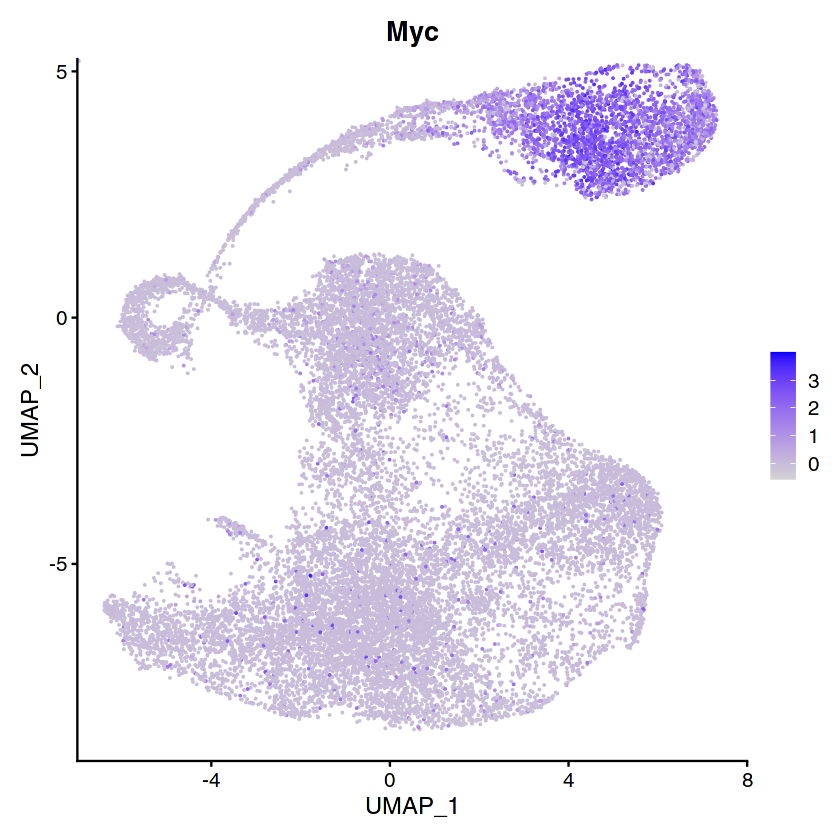

In [7]:
library(ggplot2)
FeaturePlot(tenx, "Myc")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

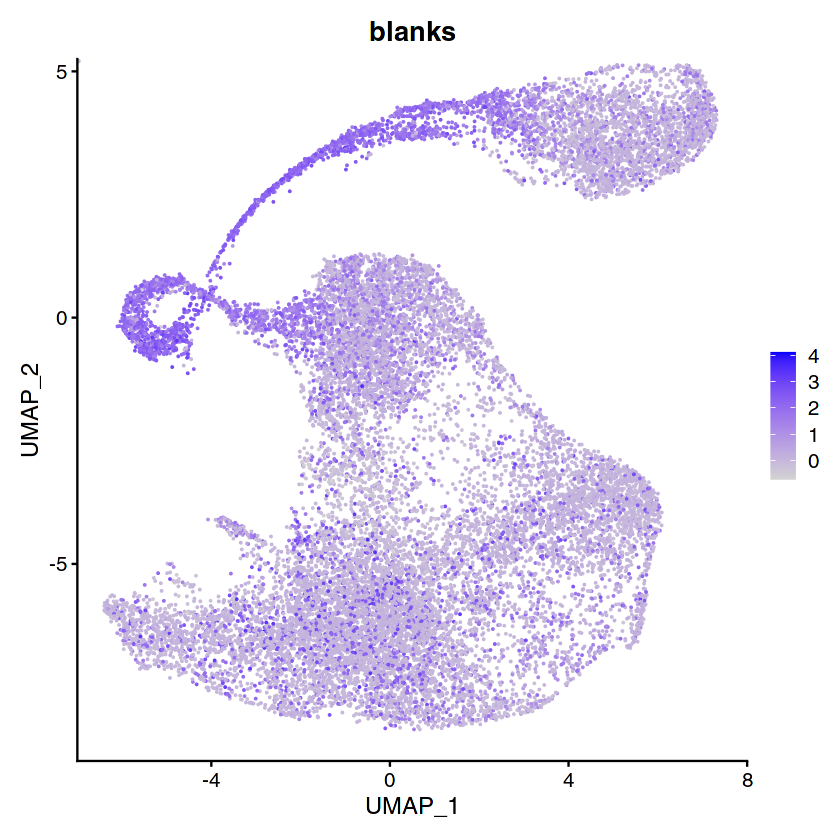

In [8]:
library(ggplot2)
FeaturePlot(tenx, "blanks")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

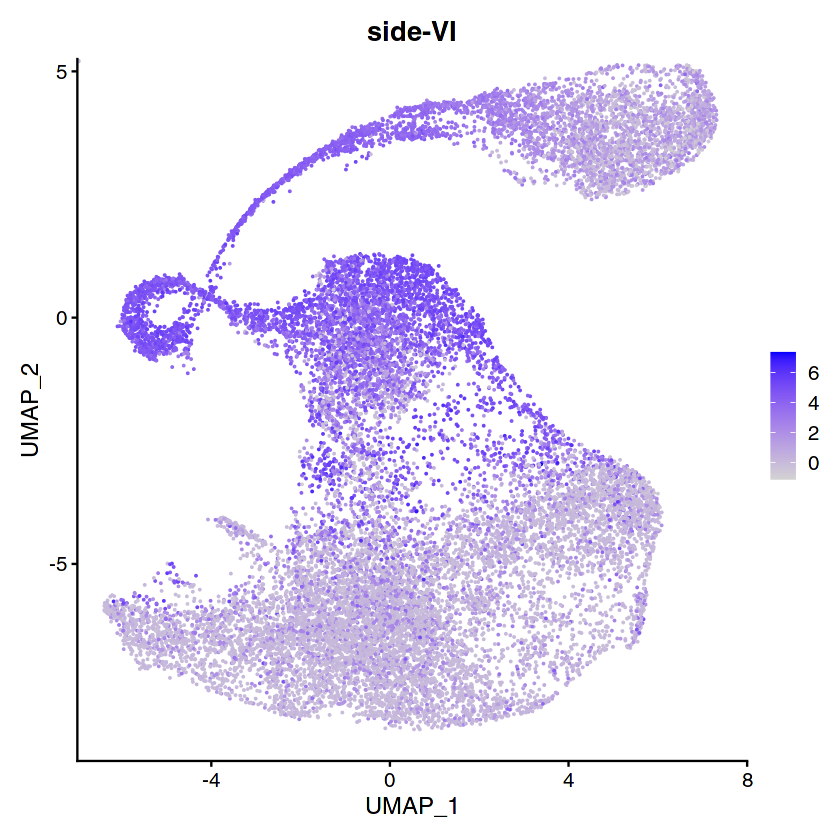

In [9]:
library(ggplot2)
FeaturePlot(tenx, "side-VI")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F)

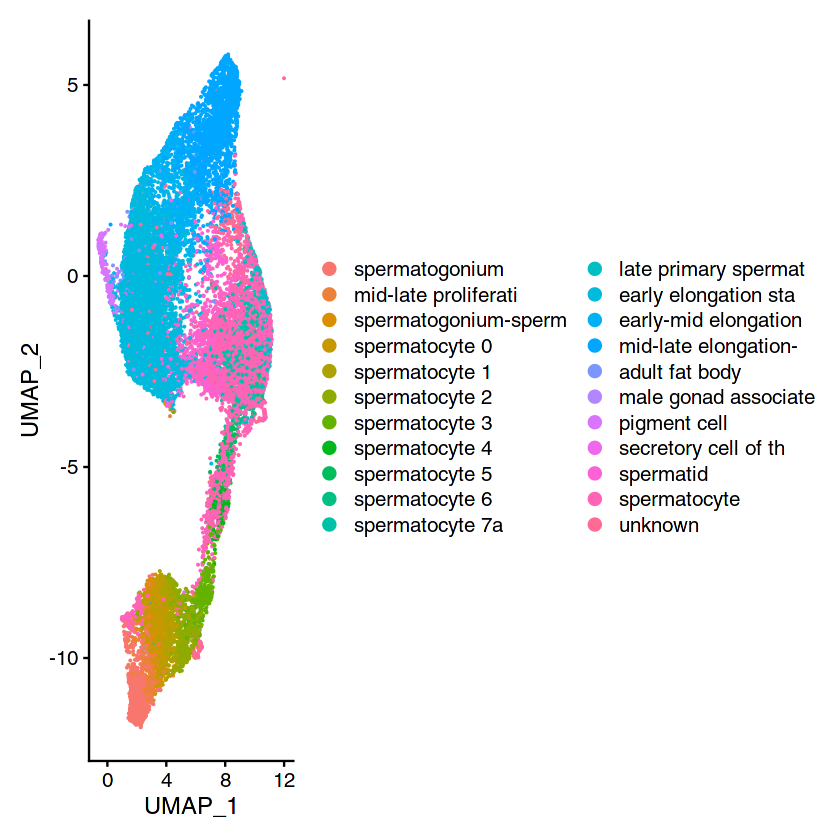

In [13]:
library(stringr)
DimPlot(
  tenx,
  cells = Cells(tenx) %>% subset(
    with(
      FetchData(tenx, c("UMAP_1", "UMAP_2")),
      between(UMAP_1, -1, 12) & between(UMAP_2, -12.5, 7)
      # between(UMAP_1, -13, -8) & between(UMAP_2, 0, 5) |
      #   between(UMAP_1, -8, 6) & between(UMAP_2, 3.5, 8)
    )
  )
) +
  scale_color_hue(
    labels = \(v) str_sub(v, 1, 20),
    # guide = guide_legend(ncol=1)
  )

In [38]:
sum(tenx$ident == "spermatogonium")

[1] 709

In [46]:
table(tenx$ident[with(FetchData(tenx, c("UMAP_1", "UMAP_2")), between(UMAP_1, xmin, xmax) & between(UMAP_2, ymin, ymax))]) %>%
  sort(dec=T) %>%
  head(10)


    early elongation stage spermatid                         spermatocyte 
                                6668                                 3677 
 mid-late elongation-stage spermatid                       spermatocyte 0 
                                2228                                  988 
early-mid elongation-stage spermatid                       spermatogonium 
                                 943                                  709 
                           spermatid                      spermatocyte 7a 
                                 643                                  593 
                      spermatocyte 1                       spermatocyte 2 
                                 582                                  541 

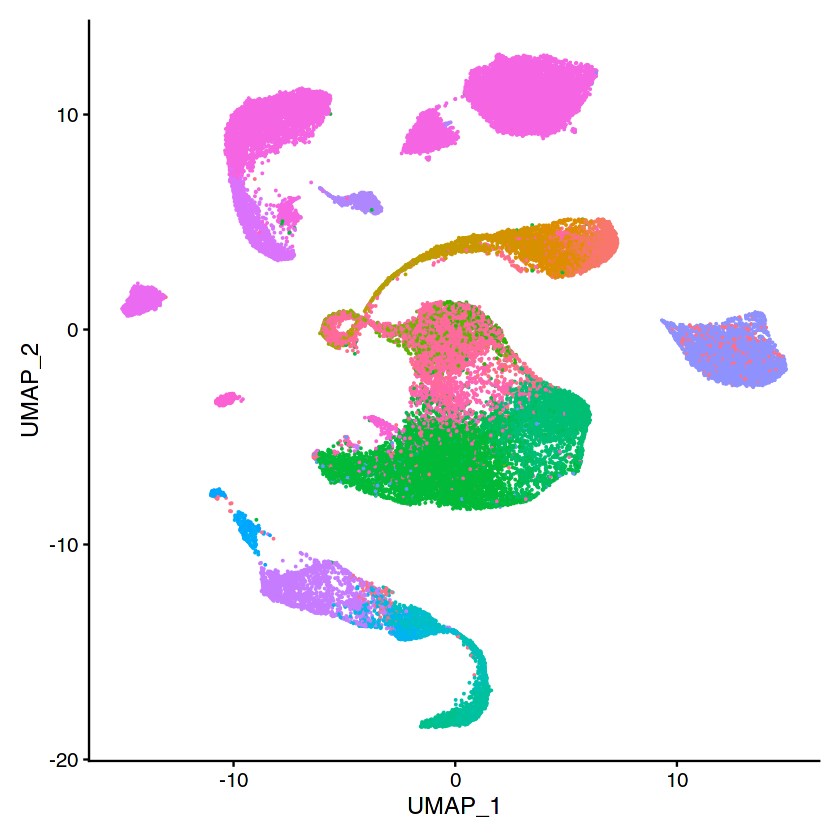

In [47]:
library(ggplot2)
DimPlot(tenx) + theme(legend.position = "none")

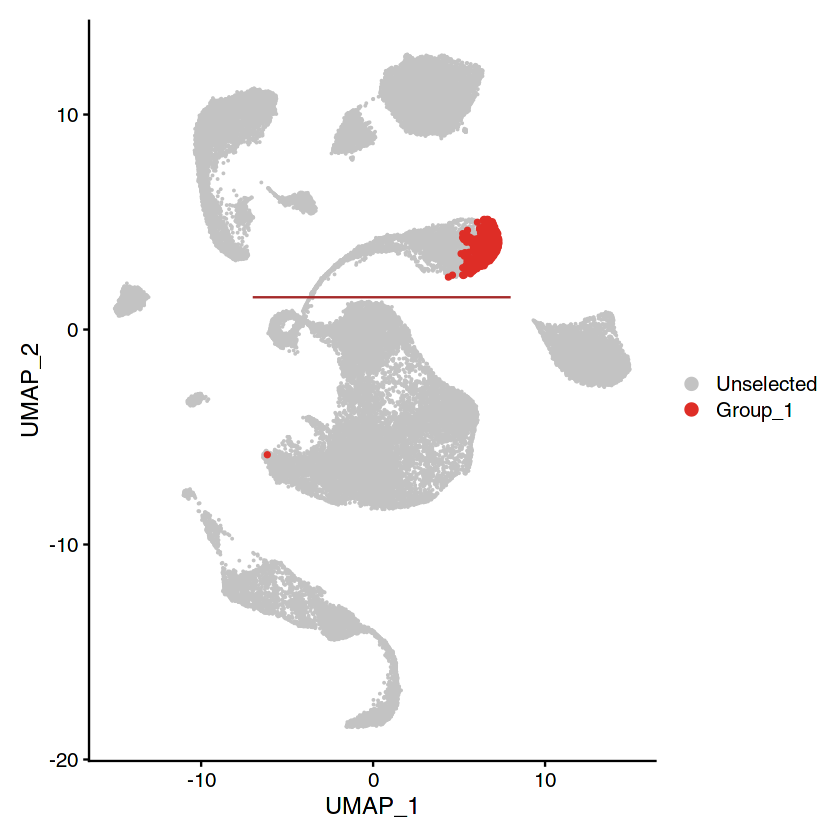

In [69]:
DimPlot(tenx ,cells.highlight = Cells(tenx) %>% subset(Idents(tenx) == "spermatogonium")) +
  annotate("line", c(xmin, xmax), rep(1.5, times=2), color="brown")

In [113]:
tenx %>%
  `DefaultAssay<-`(value = "RNA") %>%
  FetchData(c("ident", "ovo", "blanks", "side-VI")) %>%
  group_by(ident) %>%
  summarise_all(\(v) mean(v != 0))

ident                                         ovo          blanks    
1  spermatogonium                                0.6036671368 0.26516220
2  mid-late proliferating spermatogonia          0.1172069825 0.26433915
3  spermatogonium-spermatocyte transition        0.0297029703 0.17326733
4  spermatocyte 0                                0.0010121457 0.30161943
5  spermatocyte 1                                0.0017182131 0.81958763
6  spermatocyte 2                                0.0092421442 0.97966728
7  spermatocyte 3                                0.0029411765 1.00000000
8  spermatocyte 4                                0.0000000000 1.00000000
9  spermatocyte 5                                0.0055248619 0.97237569
10 spermatocyte 6                                0.0049504950 0.92574257
11 spermatocyte 7a                               0.0084317032 0.50252951
12 late primary spermatocyte                     0.0033222591 0.24916944
13 early elongation stage spermatid              0.0022451729 0.18515192
14 early-mid elongation-stage spermatid          0.0042328042 0.23386243
15 mid-late elongation-stage spermatid           0.0008976661 0.14228007
16 cyst stem cell                                0.0000000000 0.00000000
17 early cyst cell 1                             0.0030441400 0.00456621
18 early cyst cell 2                             0.0113314448 0.04249292
19 spermatocyte cyst cell branch a               0.0183299389 0.09368635
20 spermatocyte cyst cell branch b               0.0093023256 0.09767442
21 cyst cell branch a                            0.0133779264 0.06020067
22 cyst cell branch b                            0.0096463023 0.10610932
23 late cyst cell branch a                       0.0512820513 0.02564103
24 late cyst cell branch b                       0.0348101266 0.09493671
25 adult fat body                                0.0000000000 0.23853211
26 muscle cell                                   0.0000000000 0.09706803
27 adult tracheal cell                           0.5783521809 0.07915994
28 cyst cell intermediate                        0.0066777963 0.05676127
29 head cyst cell                                0.0109890110 0.03443223
30 hemocyte                                      0.0000000000 0.19000000
31 male gonad associated epithelium              0.0107565760 0.09274157
32 pigment cell                                  0.0042105263 0.22105263
33 secretory cell of the male reproductive tract 0.0341880342 0.20512821
34 spermatid                                     0.0015552100 0.19595645
35 spermatocyte                                  0.0040794126 0.43758499
36 unknown                                       0.0100548446 0.17915905
   side-VI    
1  0.657263752
2  0.638403990
3  0.287128713
4  0.688259109
5  0.974226804
6  0.996303142
7  1.000000000
8  1.000000000
9  1.000000000
10 1.000000000
11 0.994940978
12 1.000000000
13 0.222721150
14 0.286772487
15 0.272890485
16 0.000000000
17 0.000000000
18 0.000000000
19 0.000000000
20 0.000000000
21 0.000000000
22 0.000000000
23 0.000000000
24 0.000000000
25 0.247706422
26 0.000284657
27 0.000000000
28 0.000000000
29 0.000000000
30 0.000000000
31 0.000000000
32 0.111578947
33 0.247863248
34 0.889580093
35 0.880881153
36 0.322669104

Sparse PCA

If we subset to the "spermatogonium" cell type (and include the adjacent "mid-late proliferating spermatogonia"), then we can seek a factor in this subset of cells that explains optimal variance. We can try a PCA on the new object, but that may not mark a specific cell type without a range of other cell types having negative and positive PC values.

On the other hand, there is an optimal SPC1 (sparse principal component) with a fixed number of features to select, where the positive tail cell embedding values exceed the value of the negative tail cell embedding values (it is a skewed distribution). The SPC contains positive features such as "stg" (cell cycle-regulating component that nevertheless may be enriched in GSC). To start, we guessed some guided features to incorporate into the factor (positve GSC: nos, stg, piwi; negative SG/proliferating cell: blanks, Myc, bam). Next, we used power iteration and rounding (missing citation) to arrive at a stable point, which we hope is the optimal SPC1. However, we produced the same SPC1 when our initial vector has uniformly randomly selected 3 positive and 3 negative features.

In [43]:
tenx$GSC <- NULL

In [ ]:
cells <- subset(Cells(tenx), Idents(tenx) %in% c("spermatogonium", "mid-late proliferating spermatogonia"))
GSC <- crossprod(
  tenx[["integrated"]]@scale.data[with_seed(0, sample(5000, size = 6)), ],
  c(1, 1, 1, -1, -1, -1) / sqrt(6)
)[, 1]
GSC <- (GSC - mean(GSC[match(cells, Cells(tenx))])) / sd(GSC[match(cells, Cells(tenx))])
summary(GSC)
c(actual = mean(GSC[match(cells, Cells(tenx))] >= 0.5), expected = pnorm(-0.5))
c(actual = mean(GSC[match(cells, Cells(tenx))] >= 1), expected = pnorm(-1))
tenx$GSC_Score <- GSC

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.1768 -0.6366 -0.4967 -0.5265 -0.4167  3.5253 

actual  expected 
0.3117117 0.3085375

actual  expected 
0.1657658 0.1586553

In [99]:
cells <- subset(Cells(tenx), Idents(tenx) %in% c("spermatogonium", "mid-late proliferating spermatogonia"))
GSC <- crossprod(
  tenx[["integrated"]]@scale.data[c("nos", "stg", "piwi", "blanks", "Myc", "bam"), ],
  c(1, 1, 1, -1, -1, -1) / sqrt(6)
)[, 1]
GSC <- (GSC - mean(GSC[match(cells, Cells(tenx))])) / sd(GSC[match(cells, Cells(tenx))])
summary(GSC)
c(actual = mean(GSC[match(cells, Cells(tenx))] >= 0.5), expected = pnorm(-0.5))
c(actual = mean(GSC[match(cells, Cells(tenx))] >= 1), expected = pnorm(-1))
tenx$GSC_Score <- GSC

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.1768 -0.6366 -0.4967 -0.5265 -0.4167  3.5253 

actual  expected 
0.3117117 0.3085375

actual  expected 
0.1657658 0.1586553

In [100]:
cor(FetchData(tenx, c("GSC_Score", "nos", "stg", "piwi", "ovo", "HP6", "blanks", "Myc", "bam"), cells = cells))

GSC_Score   nos           stg          piwi        ovo        
GSC_Score  1.00000000  0.5643962416  0.558604552  0.42653965  0.26872481
nos        0.56439624  1.0000000000  0.008172174  0.08063674  0.06883018
stg        0.55860455  0.0081721741  1.000000000  0.09033291  0.08882679
piwi       0.42653965  0.0806367365  0.090332913  1.00000000  0.33593792
ovo        0.26872481  0.0688301775  0.088826790  0.33593792  1.00000000
HP6        0.03790311  0.0008165623  0.028490350  0.01390195 -0.01114985
blanks    -0.16795038  0.0035156972 -0.024927859 -0.03724354  0.01347345
Myc       -0.38689280 -0.0458787649 -0.061652467 -0.18936589 -0.19164682
bam       -0.54192107 -0.0760200122 -0.098885250 -0.07795975 -0.14030821
          HP6           blanks       Myc         bam         
GSC_Score  0.0379031052 -0.167950385 -0.38689280 -0.541921072
nos        0.0008165623  0.003515697 -0.04587876 -0.076020012
stg        0.0284903499 -0.024927859 -0.06165247 -0.098885250
piwi       0.0139019531 -0.037243539 -0.18936589 -0.077959753
ovo       -0.0111498466  0.013473450 -0.19164682 -0.140308209
HP6        1.0000000000 -0.010903385 -0.02241636 -0.018966728
blanks    -0.0109033853  1.000000000 -0.01257643 -0.006810707
Myc       -0.0224163649 -0.012576425  1.00000000  0.111639723
bam       -0.0189667282 -0.006810707  0.11163972  1.000000000

Warning message:
“Removed 42004 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 42004 rows containing missing values (`geom_point()`).”


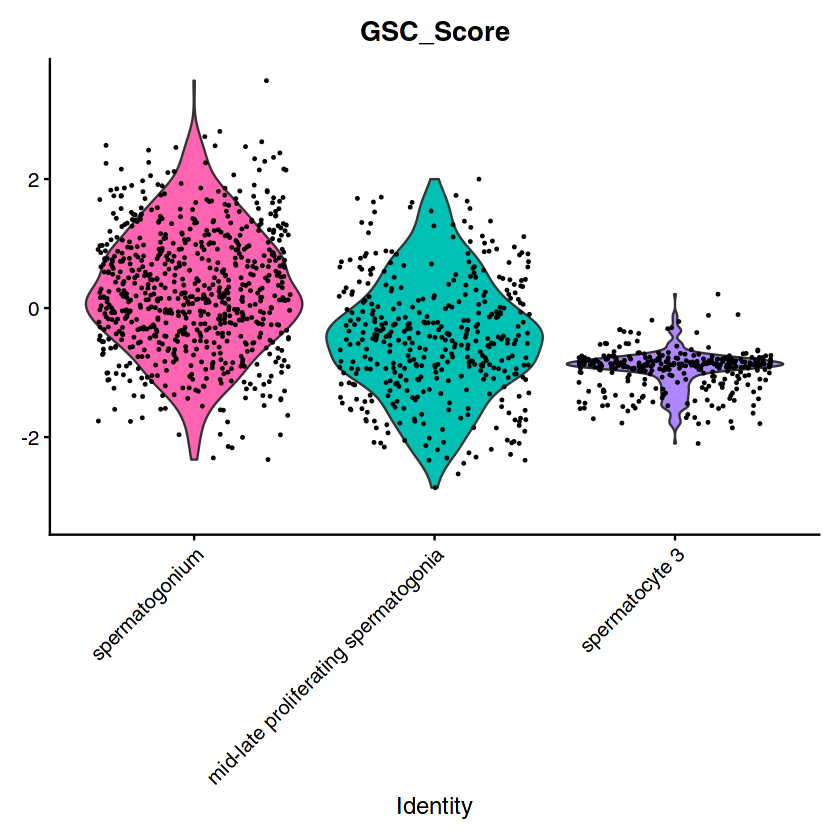

In [101]:
library(ggplot2)
VlnPlot(tenx, "GSC_Score") +
  scale_x_discrete(
    limits = c("spermatogonium", "mid-late proliferating spermatogonia", "spermatocyte 3")
  ) +
  theme(legend.position = "none")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


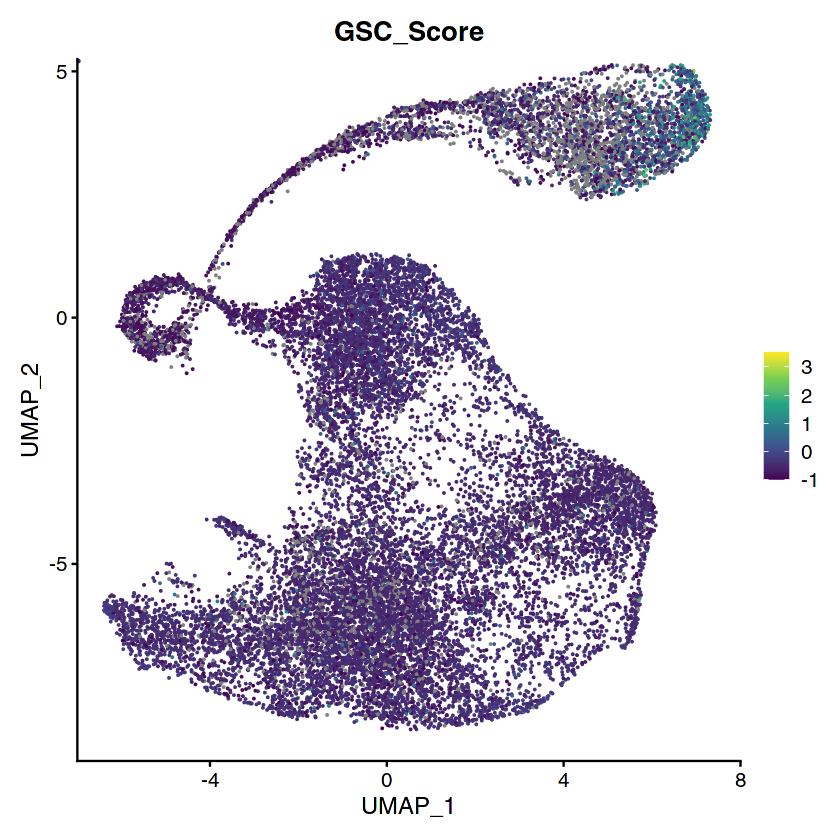

In [102]:
library(ggplot2)
FeaturePlot(tenx, "GSC_Score")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F) + scale_color_viridis_c(limits = c(-1, NA))

In [103]:
power_iteration <- function(GSC) {
  scale.data <- tenx[["integrated"]]@scale.data
  cells <- Cells(tenx) %>% subset(Idents(tenx) == c("spermatogonium", "mid-late differentiating spermatogonia"))
  feature.loadings <<- scale.data[, cells] %*% scale(GSC[cells])
  feature.loadings[abs(feature.loadings) < quantile(abs(feature.loadings), 0.95)] <- 0
  feature.loadings <<- feature.loadings / sum(feature.loadings^2)
  summary(feature.loadings)
  GSC <- crossprod(scale.data, feature.loadings)[, 1, drop=T]
  GSC <- (GSC - mean(GSC[match(cells, Cells(tenx))])) / sd(GSC[match(cells, Cells(tenx))])
}
for (i in 1:10) {
  tenx$GSC_Score <- tenx$GSC_Score %>% power_iteration()
}
c(actual = mean(tenx$GSC_Score[cells] >= 0.5), expected = pnorm(-0.5))
c(actual = mean(tenx$GSC_Score[cells] >= 1), expected = pnorm(-1))

actual  expected 
0.1837838 0.3085375

actual  expected 
0.0972973 0.1586553

In [110]:
colData$GSC_Score <- NA
colData$GSC_Score[match(Cells(tenx), colData$rowname)] <- tenx$GSC_Score
saveRDS(colData, "testis-colData.rds")

In [104]:
enframe(subset(feature.loadings, feature.loadings != 0)) %>% arrange(desc(abs(value))) %>% head(10)

name           value        
1  asRNA:CR45481   1.620715e-04
2  lncRNA:CR45667  9.612630e-05
3  Claspin         8.975756e-05
4  TM4SF           8.412554e-05
5  stg             7.715220e-05
6  SLO2            6.617669e-05
7  lncRNA:CR45665  6.412743e-05
8  Ts              5.945940e-05
9  X11Lbeta        5.901129e-05
10 Ir47a          -5.176654e-05

In [105]:
mypc <- svd(t(scale(t(tenx[["integrated"]]@scale.data)[cells, ], scale=F)))
PC_1 <- mypc$d[1] * mypc$v[, 1]
PC_2 <- mypc$d[2] * mypc$v[, 2]
PC_3 <- mypc$d[3] * mypc$v[, 3]
cor(tibble(FetchData(tenx, c("GSC_Score", "nos", "ovo", "Myc"), cells = cells), PC_1, PC_2, PC_3))

GSC_Score   nos         ovo         Myc         PC_1         
GSC_Score  1.00000000  0.03204474  0.41648509 -0.27701765 -8.734219e-01
nos        0.03204474  1.00000000  0.06883018 -0.04587876 -7.291610e-02
ovo        0.41648509  0.06883018  1.00000000 -0.19164682 -5.111482e-01
Myc       -0.27701765 -0.04587876 -0.19164682  1.00000000  2.952270e-01
PC_1      -0.87342189 -0.07291610 -0.51114822  0.29522702  1.000000e+00
PC_2      -0.24358598 -0.05665205 -0.12943716  0.13735346  5.843653e-17
PC_3      -0.29805644  0.18807253  0.22654629 -0.12297313  9.234834e-17
          PC_2          PC_3         
GSC_Score -2.435860e-01 -2.980564e-01
nos       -5.665205e-02  1.880725e-01
ovo       -1.294372e-01  2.265463e-01
Myc        1.373535e-01 -1.229731e-01
PC_1       5.843653e-17  9.234834e-17
PC_2       1.000000e+00 -8.301654e-16
PC_3      -8.301654e-16  1.000000e+00

Warning message:
“Removed 42004 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 42004 rows containing missing values (`geom_point()`).”


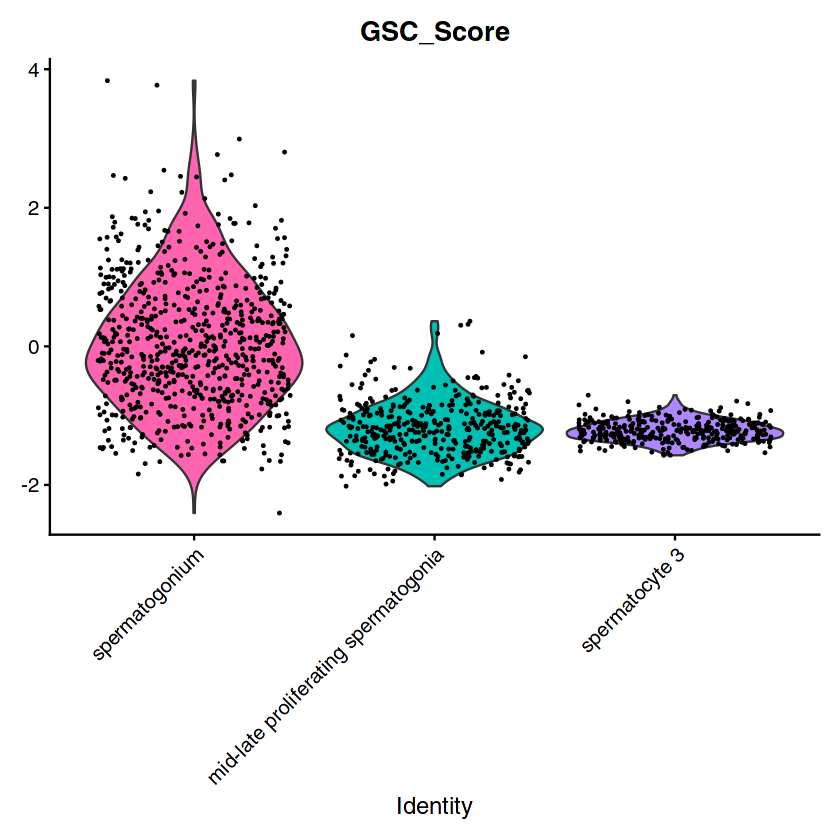

In [106]:
VlnPlot(tenx, "GSC_Score") +
  scale_x_discrete(
    limits = c("spermatogonium", "mid-late proliferating spermatogonia", "spermatocyte 3")
  ) +
  # coord_cartesian(NULL, c(0, 3)) +
  theme(legend.position = "none")

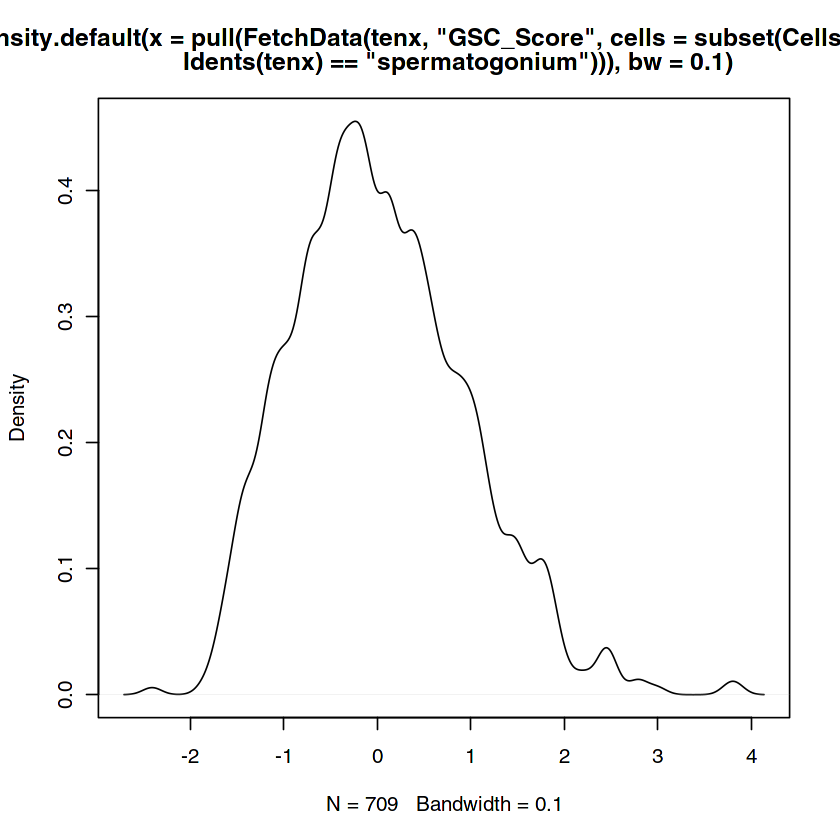

In [78]:
plot(density(pull(FetchData(tenx, "GSC_Score", cells=subset(Cells(tenx), Idents(tenx) == "spermatogonium"))), bw=0.1))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


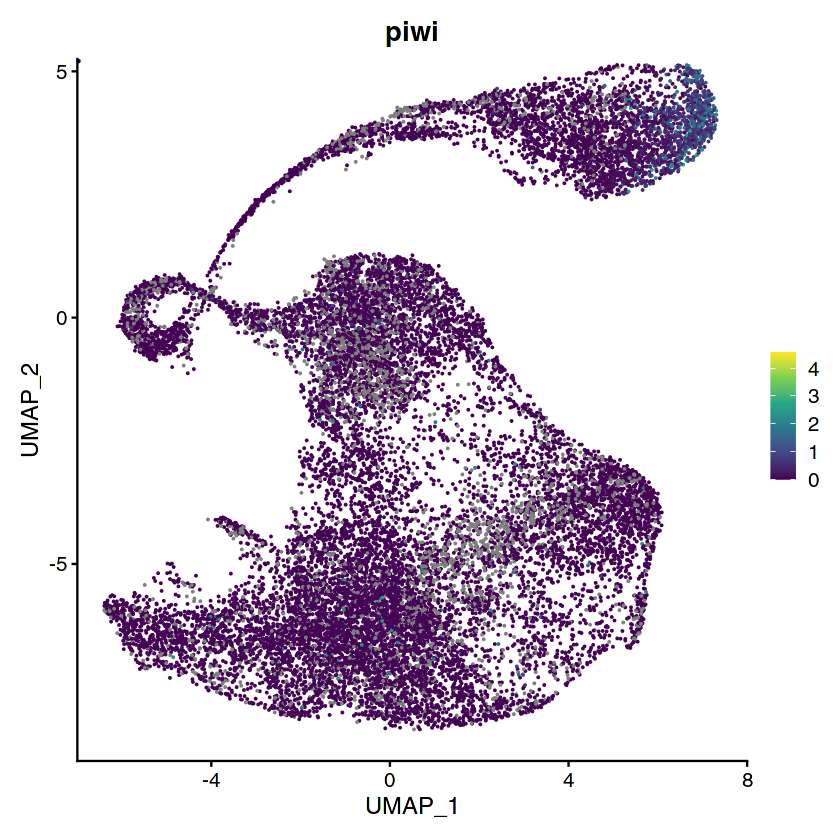

In [79]:
library(ggplot2)
FeaturePlot(tenx, "piwi")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F) + scale_color_viridis_c(limits = c(0, NA))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


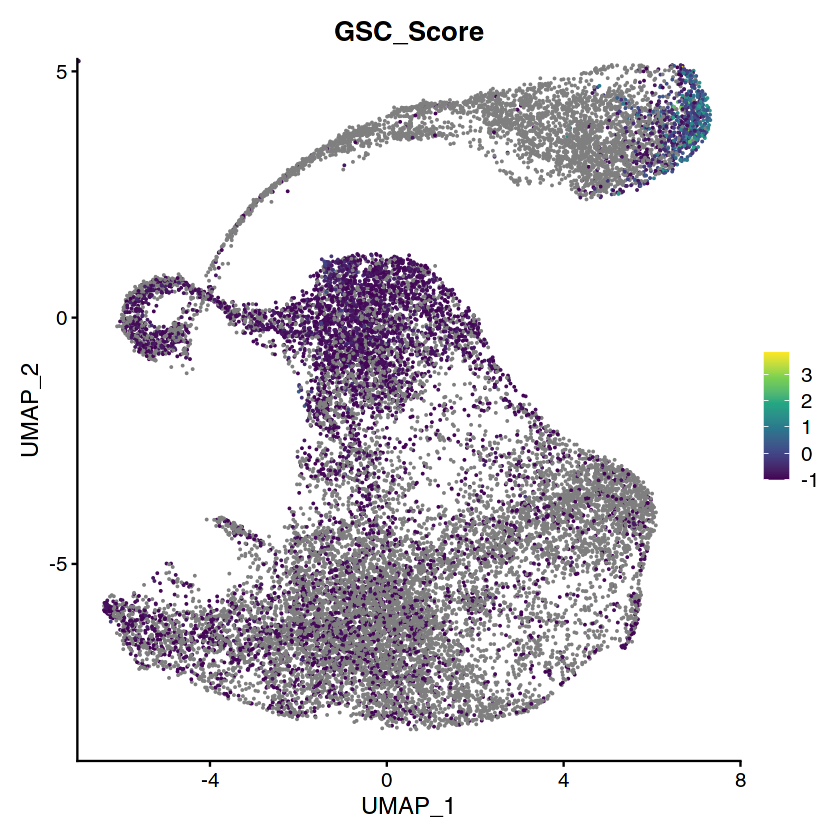

In [81]:
library(ggplot2)
FeaturePlot(tenx, "GSC_Score")  + coord_cartesian(c(xmin, xmax), c(ymin, ymax), ex=F) + scale_color_viridis_c(limits = c(-1, NA))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


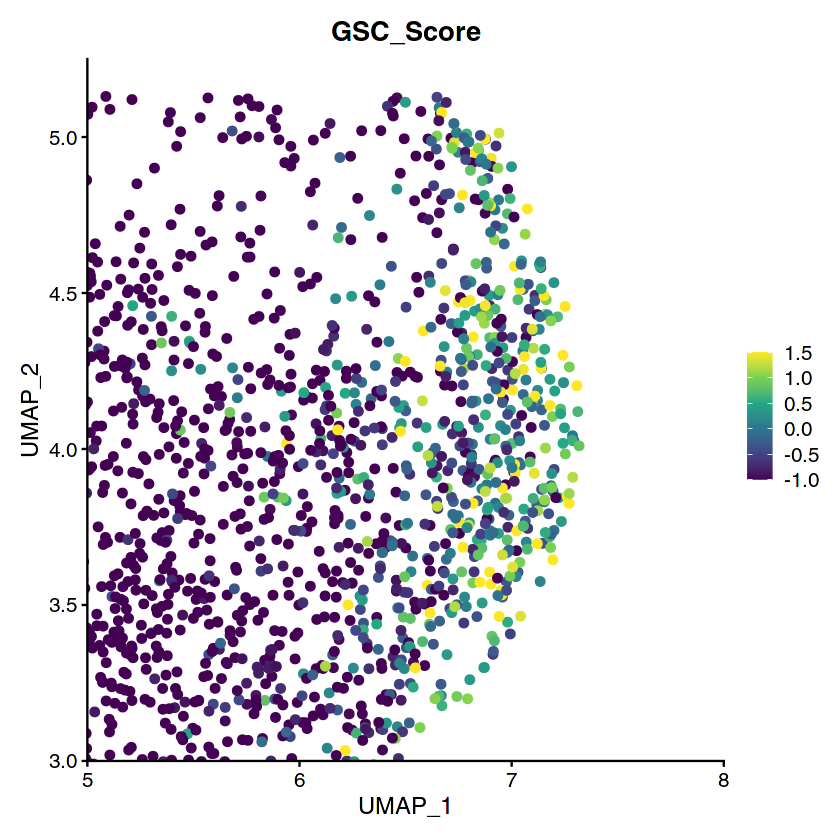

In [83]:
library(ggplot2)
FeaturePlot(tenx, "GSC_Score", pt.size=2)  + coord_cartesian(c(5, 8), c(3, 5.25), ex=F) + scale_color_viridis_c(limits = c(-1, 1.5), oob=scales::squish)

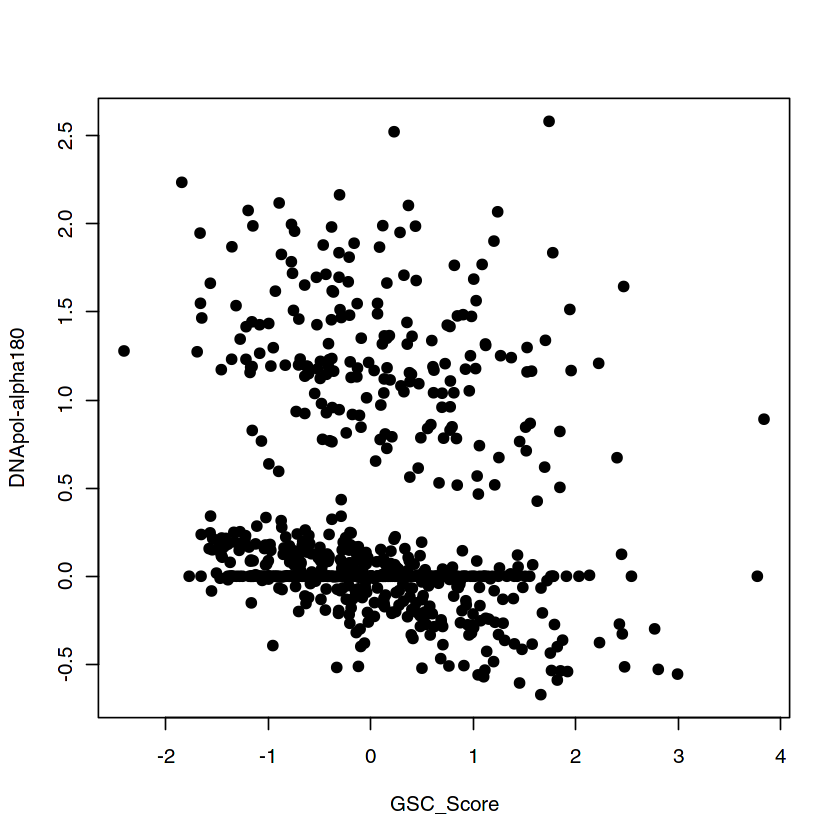

In [86]:
plot(
  FetchData(tenx, c("GSC_Score", "DNApol-alpha180")) %>%
    subset(Idents(tenx) == "spermatogonium"),
  pch = 19
)

Warning message:
“Could not find vas in the default search locations, found in RNA assay instead”


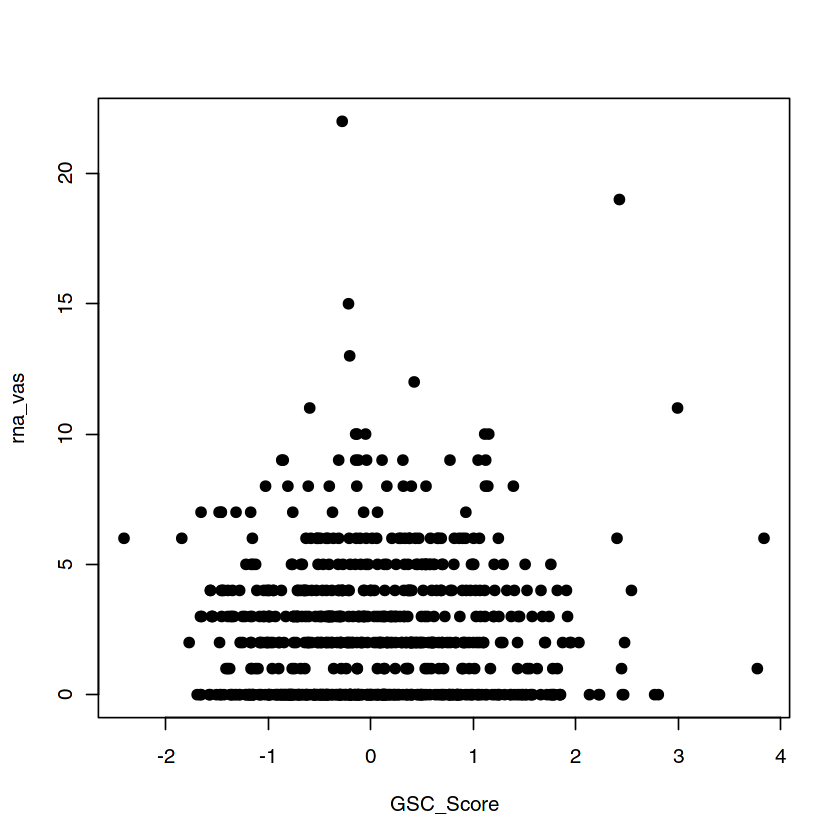

In [87]:
plot(
  FetchData(tenx, c("GSC_Score", "vas")) %>%
    subset(Idents(tenx) == "spermatogonium"),
  pch = 19
)

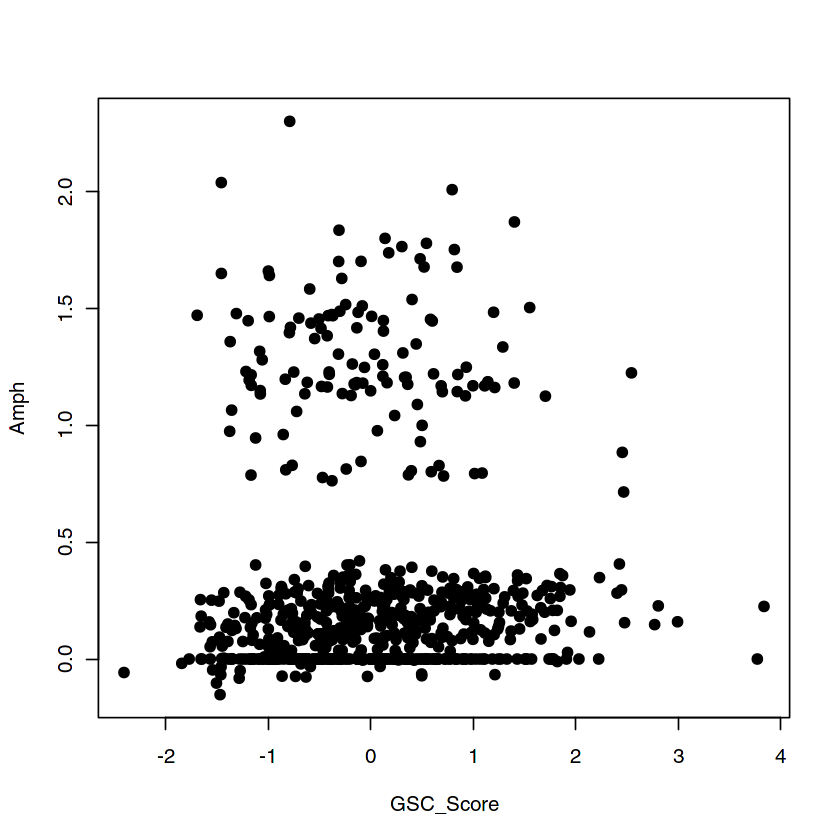

In [89]:
plot(
  FetchData(tenx, c("GSC_Score", "Amph")) %>%
    subset(Idents(tenx) == "spermatogonium"),
  pch = 19
)

Warning message:
“Could not find Mst87F in the default search locations, found in RNA assay instead”


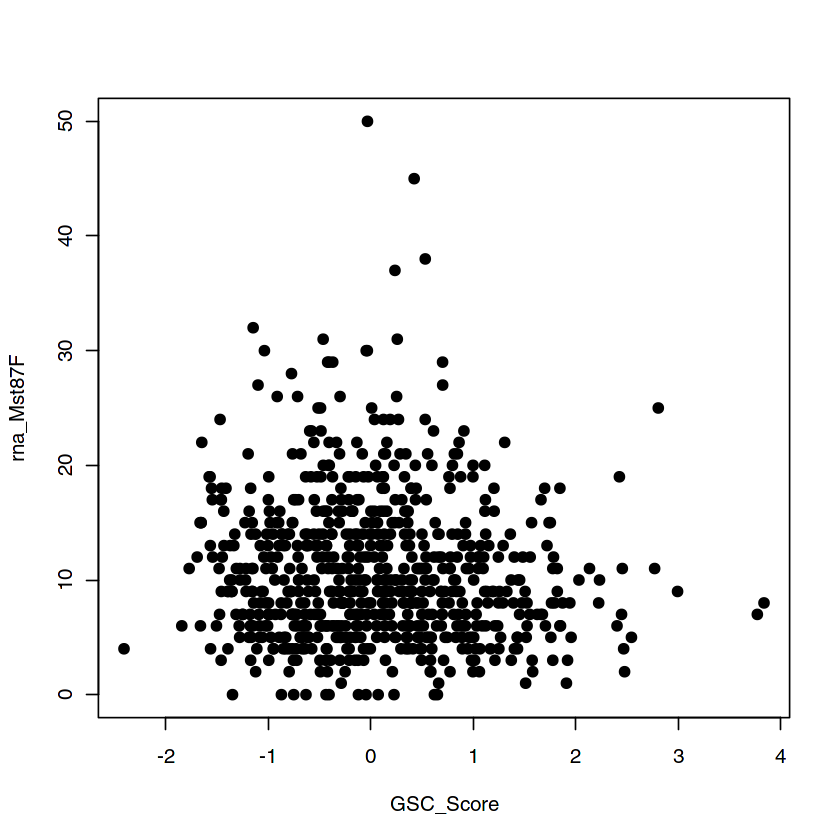

In [90]:
plot(
  FetchData(tenx, c("GSC_Score", "Mst87F")) %>%
    subset(Idents(tenx) == "spermatogonium"),
  pch = 19
)

Splitting Cluster of Interest

The SPC1 could be used as a variable to regress, or we could use it as a utility to cut the "spermatogonium" cluster. We chose the latter, because "Mst87F" starts to decline at `scale(SPC1) >= 1`. Thus, the factor of interest has a new level which has a subset of the "spermatogonium" cells.

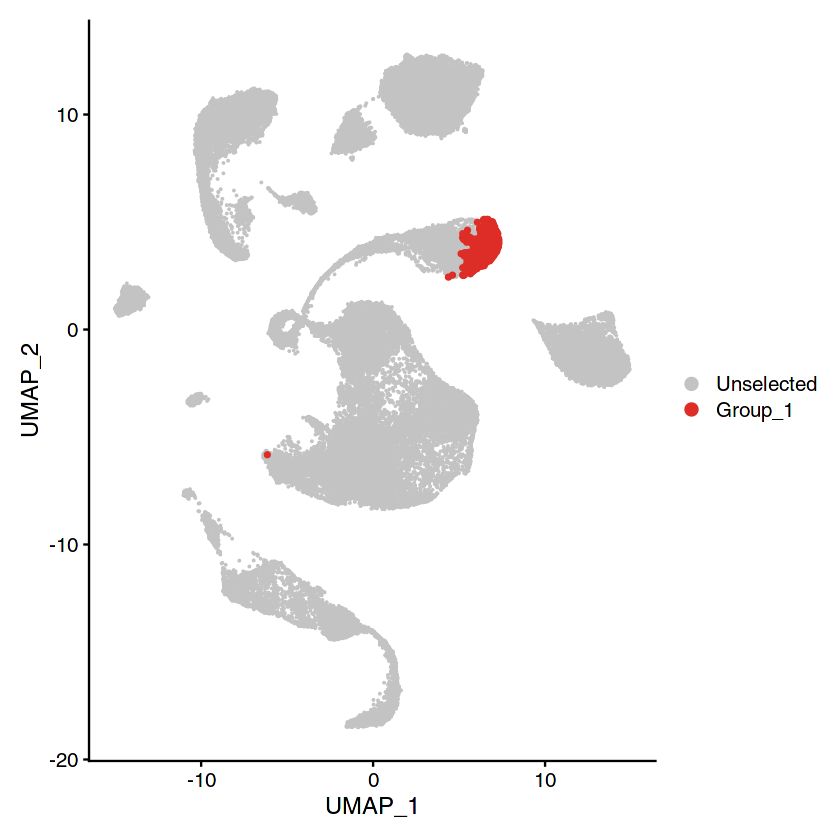

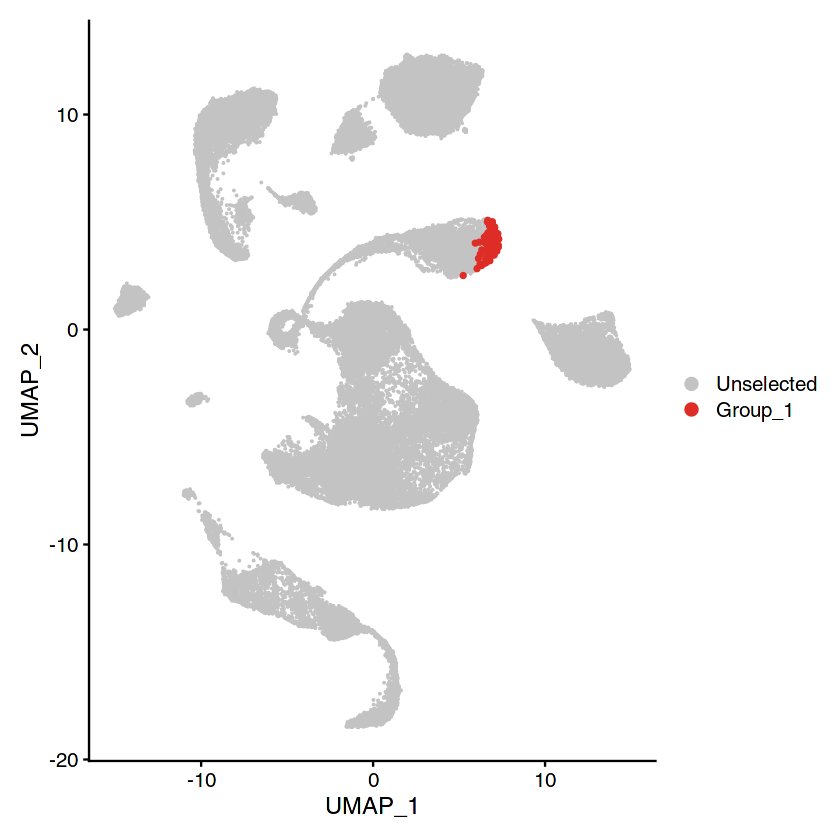

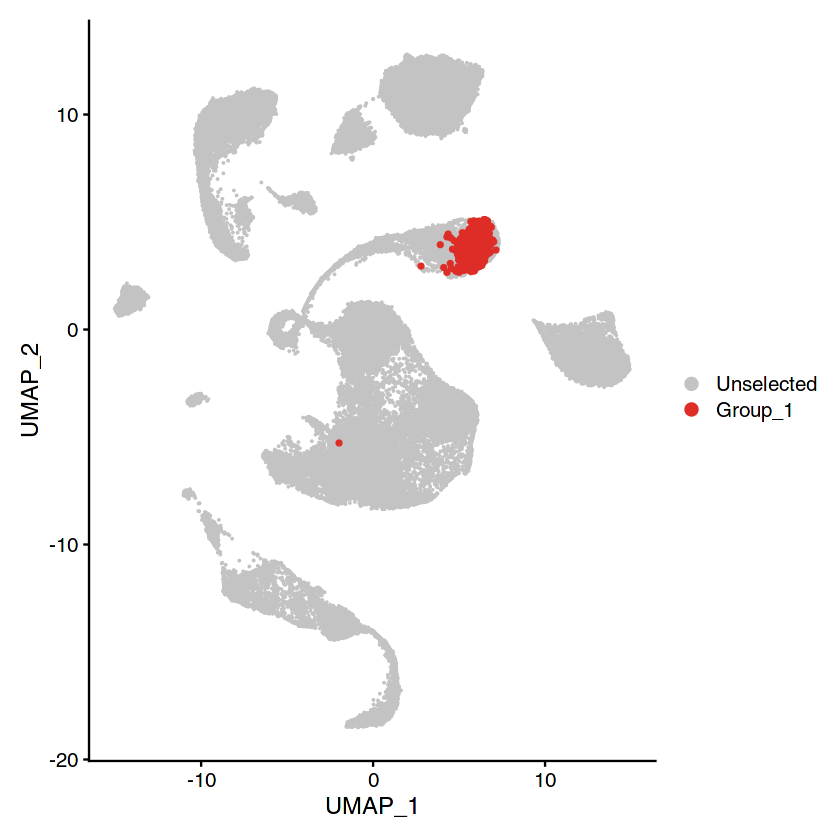

In [98]:
DimPlot(tenx ,cells.highlight = Cells(tenx) %>% subset(Idents(tenx) == "spermatogonium"))
DimPlot(tenx ,cells.highlight = Cells(tenx) %>% subset(Idents(tenx) == "spermatogonium" & tenx$GSC_Score >= 1))
DimPlot(tenx ,cells.highlight = Cells(tenx) %>% subset(Idents(tenx) == "mid-late proliferating spermatogonia"))

In [152]:
enframe(table(Idents(tenx)))

name                                          value
1  spermatogonium                                  709
2  mid-late proliferating spermatogonia            401
3  spermatogonium-spermatocyte transition          202
4  spermatocyte 0                                  988
5  spermatocyte 1                                  582
6  spermatocyte 2                                  541
7  spermatocyte 3                                  340
8  spermatocyte 4                                  146
9  spermatocyte 5                                  181
10 spermatocyte 6                                  202
11 spermatocyte 7a                                 593
12 late primary spermatocyte                       301
13 early elongation stage spermatid               6681
14 early-mid elongation-stage spermatid            945
15 mid-late elongation-stage spermatid            2228
16 cyst stem cell                                  344
17 early cyst cell 1                               657
18 early cyst cell 2                               353
19 spermatocyte cyst cell branch a                 491
20 spermatocyte cyst cell branch b                 215
21 cyst cell branch a                              299
22 cyst cell branch b                              311
23 late cyst cell branch a                         156
24 late cyst cell branch b                         316
25 adult fat body                                  109
26 muscle cell                                    3513
27 adult tracheal cell                             619
28 cyst cell intermediate                         1797
29 head cyst cell                                 1365
30 hemocyte                                        800
31 male gonad associated epithelium              11063
32 pigment cell                                    475
33 secretory cell of the male reproductive tract   117
34 spermatid                                       643
35 spermatocyte                                   3677
36 unknown                                        1094

In [179]:
library(glmGamPoi)


Attaching package: ‘glmGamPoi’


The following object is masked from ‘package:ggplot2’:

    vars


The following object is masked from ‘package:dplyr’:

    vars




In [5]:
library(dplyr)
library(HDF5Array)
Y <- readRDS("testis-counts.rds")
colData <- readRDS("testis-colData.rds")
tenx_counts <- Y[, colData$batch %in% c("sample1", "sample2", "sample3")]
tenx_counts <- tenx_counts %>% writeHDF5Array(filepath="testis-counts-10x.h5", with.dimnames=T)

In [2]:
library(dplyr)
library(forcats)
colData <- readRDS("testis-colData.rds")
ident <- colData$ident %>%
  factor(c("germline stem cell", levels(.))) %>%
  replace(
    . == "spermatogonium" & colData$GSC_Score >= 1,
    "germline stem cell"
  ) %>%
  fct_recode(spermatogonium="mid-late proliferating spermatogonia") %>%
  fct_relevel("spermatocyte 0") %>%
  droplevels()
table(ident)

ident
                               spermatocyte 0 
                                          999 
                           germline stem cell 
                                          108 
                               spermatogonium 
                                         1015 
       spermatogonium-spermatocyte transition 
                                          204 
                               spermatocyte 1 
                                          586 
                               spermatocyte 2 
                                          544 
                               spermatocyte 3 
                                          344 
                               spermatocyte 4 
                                          147 
                               spermatocyte 5 
                                          187 
                               spermatocyte 6 
                                          205 
                              spermatocyte 7a 
       

In [3]:
logFeature <- log(colData$nFeature_RNA) / log(10)
summary(logFeature)
X <- model.matrix(
  ~ ident + batch + pctMito + pctRibo + logFeature,
  as_tibble(
    as.list(colData) %>%
      replace(match("ident", names(.)), list(ident)) %>%
      replace(match("batch", names(.)), list(colData$batch %>% factor(c("sample1", "sample2", "sample3")) %>% `contrasts<-`(value = contr.sum(3)))) %>%
      append(list(logFeature = logFeature))
  ) %>%
    subset(batch %in% c("sample1", "sample2", "sample3"))
)
summary(svd(X)$d)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.845   2.980   3.108   3.121   3.263   3.911 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   4.029   15.061   22.900   64.546   39.583 1008.438 

In [ ]:
library(glmGamPoi)
glm <- with(
  subset(colData, batch %in% c("sample1", "sample2", "sample3")),
  glm_gp(
    tenx_counts,
    X,
    size_factors = size_factor,
    verbose = TRUE
  )
)

Make initial dispersion estimate

Make initial beta estimate

Estimate beta

Estimate dispersion

